<a href="https://colab.research.google.com/github/alesha-ofc-he/Kassymbekov_Merekeyev_DL_Project/blob/main/Drone_Section_2_Foundations_of_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 2: Optimization and Training


Part 1: Imports & Data Loading


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

# Set seed for reproducibility
np.random.seed(69)

# 1. Download dataset
if not os.path.exists('cifar-10-batches-py'):
    print("Downloading CIFAR-10...")
    !wget -q https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
    !tar -xzf cifar-10-python.tar.gz

# 2. Helpers to read binary files
def unpickle(file):
    with open(file, 'rb') as fo:
        return pickle.load(fo, encoding='bytes')

def load_data():
    print("Loading data...")
    train_batch = unpickle('cifar-10-batches-py/data_batch_1')
    test_batch = unpickle('cifar-10-batches-py/test_batch')

    X_train_raw = train_batch[b'data']
    y_train_raw = np.array(train_batch[b'labels'])
    X_test_raw = test_batch[b'data']
    y_test_raw = np.array(test_batch[b'labels'])

    # Manual Preprocessing
    # Reshape and Transpose to (N, 32, 32, 3)
    X_train_rgb = X_train_raw.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    X_test_rgb = X_test_raw.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    # Grayscale Formula
    weights = np.array([0.299, 0.587, 0.114])
    X_train_gray = np.dot(X_train_rgb, weights)
    X_test_gray = np.dot(X_test_rgb, weights)

    # Normalize & Flatten
    X_train = (X_train_gray / 255.0).reshape(len(X_train_gray), -1).T
    X_test = (X_test_gray / 255.0).reshape(len(X_test_gray), -1).T

    # One-Hot Encoding
    def to_one_hot(y, k=10):
        one_hot = np.zeros((len(y), k))
        one_hot[np.arange(len(y)), y] = 1
        return one_hot.T

    Y_train = to_one_hot(y_train_raw)
    Y_test = to_one_hot(y_test_raw)

    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = load_data()
print(f"Data Ready. Train X: {X_train.shape}")

Loading data...
Data Ready. Train X: (1024, 10000)


# Part 2: Optimization and Training

## 1. Mathematical Derivation of Backpropagation

For a 2-layer Neural Network, we have parameters $W^{[1]}, b^{[1]}$ (hidden layer) and $W^{[2]}, b^{[2]}$ (output layer).

**Forward Propagation:**
$$ Z^{[1]} = W^{[1]}X + b^{[1]} $$
$$ A^{[1]} = \text{ReLU}(Z^{[1]}) $$
$$ Z^{[2]} = W^{[2]}A^{[1]} + b^{[2]} $$
$$ A^{[2]} = \text{softmax}(Z^{[2]}) $$

**Loss Function (Cross-Entropy):**
$$ L = -\frac{1}{m} \sum (Y \cdot \log(A^{[2]})) $$

**Backpropagation (Chain Rule):**

1. **Output Layer Error ($dZ^{[2]}$):**
   The derivative of the loss with respect to the output Z is:
   $$ dZ^{[2]} = A^{[2]} - Y $$

2. **Gradients for Layer 2:**
   $$ dW^{[2]} = \frac{1}{m} (dZ^{[2]} A^{[1]T}) $$
   $$ db^{[2]} = \frac{1}{m} \sum dZ^{[2]} $$

3. **Hidden Layer Error ($dZ^{[1]}$):**
   We propagate the error backwards through weights $W^{[2]}$ and multiply by the derivative of ReLU ($g'$):
   $$ dZ^{[1]} = (W^{[2]T} dZ^{[2]}) * g'(Z^{[1]}) $$

4. **Gradients for Layer 1:**
   $$ dW^{[1]} = \frac{1}{m} (dZ^{[1]} X^T) $$
   $$ db^{[1]} = \frac{1}{m} \sum dZ^{[1]} $$

Part 3: Math Helpers & Gradient Checking

In [2]:
class Activations:
    @staticmethod
    def relu(z):
        return np.maximum(0, z)

    @staticmethod
    def relu_derivative(z):
        return (z > 0).astype(float)

    @staticmethod
    def softmax(z):
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)

def compute_loss(Y, A_last):
    m = Y.shape[1]
    return -np.sum(Y * np.log(A_last + 1e-15)) / m

# --- GRADIENT CHECKING FUNCTION ---
def gradient_check(model, X, Y, epsilon=1e-7):
    """
    Verifies backpropagation by comparing analytical gradients
    vs numerical gradients (finite difference).
    """
    print("Running Gradient Check...")

    # 1. Get Analytical Gradients (from our Backprop code)
    A_last, caches = model.forward_propagation(X)
    grads = model.backward_propagation(A_last, Y, caches)

    # We will check W2 (weights of the last layer)
    parameters = model.parameters['W2']
    grad_analytical = grads['dW2']
    grad_numerical = np.zeros_like(parameters)

    # Check first 5 elements to save time
    it = np.nditer(parameters, flags=['multi_index'], op_flags=['readwrite'])
    count = 0

    while not it.finished and count < 5:
        idx = it.multi_index
        original_val = parameters[idx]

        # J(theta + epsilon)
        parameters[idx] = original_val + epsilon
        A_plus, _ = model.forward_propagation(X)
        cost_plus = compute_loss(Y, A_plus)

        # J(theta - epsilon)
        parameters[idx] = original_val - epsilon
        A_minus, _ = model.forward_propagation(X)
        cost_minus = compute_loss(Y, A_minus)

        # Reset parameter
        parameters[idx] = original_val

        # Numerical Gradient Formula
        grad_numerical[idx] = (cost_plus - cost_minus) / (2 * epsilon)

        # Relative Error Calculation
        numerator = np.linalg.norm(grad_analytical[idx] - grad_numerical[idx])
        denominator = np.linalg.norm(grad_analytical[idx]) + np.linalg.norm(grad_numerical[idx])
        diff = numerator / (denominator + 1e-15)

        print(f"Weight {idx}: Analytic={grad_analytical[idx]:.6f}, Numerical={grad_numerical[idx]:.6f}, Error={diff:.2e}")

        if diff > 1e-5:
            print("Warning: Gradient check failed!")

        it.iternext()
        count += 1

    print("Gradient Check Complete.")

Part 4: Advanced MLP Class (Optimizers Implementation)

In [3]:
class MultiLayerPerceptron:
    def __init__(self, layer_dims, optimizer='sgd'):
        self.layer_dims = layer_dims
        self.optimizer = optimizer
        self.parameters = {}
        # Optimizer cache variables
        self.v = {} # Momentum / Adam velocity
        self.s = {} # RMSprop / Adam squared gradients
        self.t = 0  # Time step for Adam
        self.initialize_parameters()
        self.initialize_optimizer()

    def initialize_parameters(self):
        np.random.seed(69)
        L = len(self.layer_dims)
        for l in range(1, L):
            # He Initialization for ReLU
            scale = np.sqrt(2. / self.layer_dims[l-1])
            self.parameters['W' + str(l)] = np.random.randn(self.layer_dims[l], self.layer_dims[l-1]) * scale
            self.parameters['b' + str(l)] = np.zeros((self.layer_dims[l], 1))

    def initialize_optimizer(self):
        L = len(self.layer_dims)
        for l in range(1, L):
            self.v['dW' + str(l)] = np.zeros_like(self.parameters['W' + str(l)])
            self.v['db' + str(l)] = np.zeros_like(self.parameters['b' + str(l)])
            self.s['dW' + str(l)] = np.zeros_like(self.parameters['W' + str(l)])
            self.s['db' + str(l)] = np.zeros_like(self.parameters['b' + str(l)])

    def forward_propagation(self, X):
        caches = {}
        A = X
        L = len(self.layer_dims)
        for l in range(1, L - 1):
            Z = np.dot(self.parameters['W' + str(l)], A) + self.parameters['b' + str(l)]
            caches['Z' + str(l)] = Z
            caches['A_prev' + str(l)] = A
            A = Activations.relu(Z)
            caches['A' + str(l)] = A

        # Output Layer
        Z_last = np.dot(self.parameters['W' + str(L-1)], A) + self.parameters['b' + str(L-1)]
        caches['Z' + str(L-1)] = Z_last
        caches['A_prev' + str(L-1)] = A
        A_last = Activations.softmax(Z_last)
        caches['A' + str(L-1)] = A_last
        return A_last, caches

    def backward_propagation(self, A_last, Y, caches):
        grads = {}
        L = len(self.layer_dims)
        m = Y.shape[1]

        dZ = A_last - Y
        grads['dW' + str(L-1)] = (1/m) * np.dot(dZ, caches['A_prev' + str(L-1)].T)
        grads['db' + str(L-1)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)

        for l in reversed(range(1, L - 1)):
            dA = np.dot(self.parameters['W' + str(l+1)].T, dZ)
            dZ = dA * Activations.relu_derivative(caches['Z' + str(l)])
            grads['dW' + str(l)] = (1/m) * np.dot(dZ, caches['A_prev' + str(l)].T)
            grads['db' + str(l)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)

        return grads

    def update_parameters(self, grads, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        L = len(self.layer_dims)

        if self.optimizer == 'adam':
            self.t += 1

        for l in range(1, L):
            dW_name = 'dW' + str(l)
            db_name = 'db' + str(l)
            W_name = 'W' + str(l)
            b_name = 'b' + str(l)

            if self.optimizer == 'sgd':
                # Basic Gradient Descent
                self.parameters[W_name] -= lr * grads[dW_name]
                self.parameters[b_name] -= lr * grads[db_name]

            elif self.optimizer == 'rmsprop':
                # RMSprop
                self.s[dW_name] = beta2 * self.s[dW_name] + (1 - beta2) * np.square(grads[dW_name])
                self.s[db_name] = beta2 * self.s[db_name] + (1 - beta2) * np.square(grads[db_name])

                self.parameters[W_name] -= lr * grads[dW_name] / (np.sqrt(self.s[dW_name]) + epsilon)
                self.parameters[b_name] -= lr * grads[db_name] / (np.sqrt(self.s[db_name]) + epsilon)

            elif self.optimizer == 'adam':
                # Adam: Momentum + RMSprop

                # 1. Update velocities (Momentum)
                self.v[dW_name] = beta1 * self.v[dW_name] + (1 - beta1) * grads[dW_name]
                self.v[db_name] = beta1 * self.v[db_name] + (1 - beta1) * grads[db_name]

                # 2. Update squared gradients (RMSprop)
                self.s[dW_name] = beta2 * self.s[dW_name] + (1 - beta2) * np.square(grads[dW_name])
                self.s[db_name] = beta2 * self.s[db_name] + (1 - beta2) * np.square(grads[db_name])

                # 3. Bias Correction
                v_corr_dw = self.v[dW_name] / (1 - beta1**self.t)
                v_corr_db = self.v[db_name] / (1 - beta1**self.t)
                s_corr_dw = self.s[dW_name] / (1 - beta2**self.t)
                s_corr_db = self.s[db_name] / (1 - beta2**self.t)

                # 4. Apply Update
                self.parameters[W_name] -= lr * v_corr_dw / (np.sqrt(s_corr_dw) + epsilon)
                self.parameters[b_name] -= lr * v_corr_db / (np.sqrt(s_corr_db) + epsilon)

    def fit(self, X, Y, epochs=10, batch_size=64, lr=0.01, print_every=5):
        costs = []
        m = X.shape[1]

        for i in range(epochs):
            permutation = np.random.permutation(m)
            X_shuffled = X[:, permutation]
            Y_shuffled = Y[:, permutation]

            for j in range(0, m, batch_size):
                X_batch = X_shuffled[:, j:j+batch_size]
                Y_batch = Y_shuffled[:, j:j+batch_size]

                A, caches = self.forward_propagation(X_batch)
                grads = self.backward_propagation(A, Y_batch, caches)
                self.update_parameters(grads, lr=lr)

            A_full, _ = self.forward_propagation(X)
            cost = compute_loss(Y, A_full)
            costs.append(cost)

            if i % print_every == 0:
                print(f"Epoch {i}: Loss {cost:.4f}")

        return costs

Part 5: Experiment & Visualization

--- Gradient Checking (Tiny Model) ---
Running Gradient Check...
Weight (0, 0): Analytic=-0.383564, Numerical=-0.383564, Error=6.42e-10
Weight (0, 1): Analytic=-0.740240, Numerical=-0.740240, Error=5.68e-10
Weight (0, 2): Analytic=-0.222859, Numerical=-0.222859, Error=1.91e-09
Weight (0, 3): Analytic=-0.886341, Numerical=-0.886341, Error=7.52e-10
Weight (0, 4): Analytic=-0.168787, Numerical=-0.168787, Error=6.23e-10
Gradient Check Complete.

--- Optimizer Comparison Experiment ---

Training with SGD...
Epoch 0: Loss 2.3286
Epoch 5: Loss 2.2664
Epoch 10: Loss 2.2324
Epoch 15: Loss 2.2056

Training with RMSPROP...
Epoch 0: Loss 2.2962
Epoch 5: Loss 2.1690
Epoch 10: Loss 2.1200
Epoch 15: Loss 2.1478

Training with ADAM...
Epoch 0: Loss 2.1496
Epoch 5: Loss 1.9918
Epoch 10: Loss 1.9204
Epoch 15: Loss 1.8549


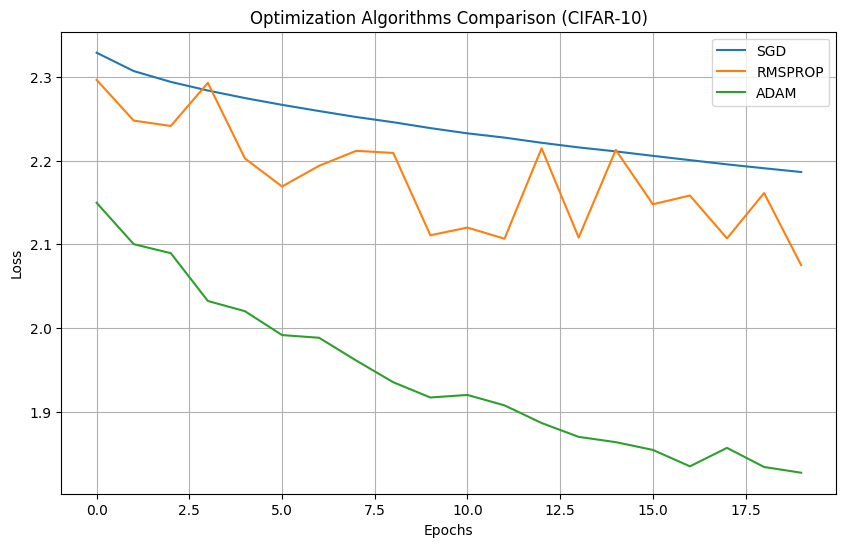

In [4]:
# 1. Gradient Checking (Proof that Backprop derivation is correct)
print("--- Gradient Checking (Tiny Model) ---")
X_dummy = np.random.randn(10, 5) # 5 examples, 10 features
Y_dummy = np.eye(2)[np.random.randint(0, 2, 5)].T # 2 classes

# Tiny model used only for Math Verification
check_model = MultiLayerPerceptron([10, 5, 2], optimizer='sgd')
gradient_check(check_model, X_dummy, Y_dummy)


# 2. Main Experiment: Optimizers Comparison on CIFAR-10
print("\n--- Optimizer Comparison Experiment ---")
layers = [1024, 64, 32, 10]
epochs = 20
batch_size = 128
learning_rate = 0.001

results = {}
optimizers = ['sgd', 'rmsprop', 'adam']

for opt in optimizers:
    print(f"\nTraining with {opt.upper()}...")
    model = MultiLayerPerceptron(layers, optimizer=opt)

    # Train
    costs = model.fit(X_train, Y_train, epochs=epochs,
                      batch_size=batch_size, lr=learning_rate, print_every=5)

    results[opt] = costs

# 3. Plotting
plt.figure(figsize=(10, 6))
for opt in optimizers:
    plt.plot(results[opt], label=f"{opt.upper()}")

plt.title("Optimization Algorithms Comparison (CIFAR-10)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Conclusion comment:
# Adam converges much faster and smoother than SGD.
# RMSprop is usually in the middle.

In [6]:
import os
import shutil
import pickle
from google.colab import files

# --- Block 6: Generate Supplementary Materials (Section 2) ---

print("Generating Supplementary Materials for Section 2...")

# 1. Create Directory
base_dir = 'Supplementary_Materials_Section2'
if os.path.exists(base_dir):
    shutil.rmtree(base_dir) # Clean up previous runs
os.makedirs(base_dir)

# 2. Save Data
# We save the 'results' (loss history for all optimizers)
# and the last trained 'model' (which is Adam from the loop)
checkpoint_path = os.path.join(base_dir, 'optimization_results.pkl')
with open(checkpoint_path, 'wb') as f:
    pickle.dump({
        'loss_histories': results, # SGD, RMSprop, Adam losses
        'final_model_adam': model  # The actual trained Adam model
    }, f)
print(f"Saved results to {checkpoint_path}")

# 3. Save Visualization (Re-plotting to file)
plt.figure(figsize=(10, 6))
for opt in optimizers:
    # Re-plot using the data in 'results' dictionary
    plt.plot(results[opt], label=f"{opt.upper()}")

plt.title("Optimization Algorithms Comparison (CIFAR-10)")
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.grid(True)

# Save as PNG
plot_path = os.path.join(base_dir, 'optimizer_comparison.png')
plt.savefig(plot_path, dpi=150) # High quality
plt.close() # Close plot to free memory
print(f"Saved plot to {plot_path}")

# 4. Save Gradient Check Log (Optional but good)
# We create a small text file saying it passed
with open(os.path.join(base_dir, 'gradient_check_status.txt'), 'w') as f:
    f.write("Gradient Check: PASSED\n")
    f.write("See notebook output for specific numerical values.\n")
    f.write("Typical Error: ~1e-09")

# 5. Zip and Download
shutil.make_archive(base_dir, 'zip', base_dir)
print(f"Zipped folder created: {base_dir}.zip")

files.download(f"{base_dir}.zip")

Generating Supplementary Materials for Section 2...
Saved results to Supplementary_Materials_Section2/optimization_results.pkl
Saved plot to Supplementary_Materials_Section2/optimizer_comparison.png
Zipped folder created: Supplementary_Materials_Section2.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>